In [1]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from agents import *
from environment import *

In [4]:
DISCOUNT = 0.6

In [5]:
print(f"Discount: {DISCOUNT}. Epsilon: {EPSILON}")

Discount: 0.6. Epsilon: 0.25


In [6]:
def plot_heat_maps(value_array, policy_array, reward, penalty):
    _, axes = plt.subplots(2, 1, figsize=(15, 30))
    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    matplotlib.rcParams.update({'font.size': 22})
    plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=14)    # fontsize of the tick labels

    axes = axes.flatten()
    axes[0].set_title(
        f'Value Function -- Reward: {reward} Penalty: {penalty} Discount: {DISCOUNT}', 
        fontsize=20
    )

    fig = sns.heatmap(
    #     np.flipud(results), 
        value_array,
        cmap="YlGnBu", 
        ax=axes[0],
    )
    fig.set_ylabel('# Old Vaccines ', fontsize=20)
    fig.set_xlabel('# New Vaccines ', fontsize=20)

    
    axes[1].set_title(
        f'Policy -- Reward: {reward} Penalty: {penalty} Discount: {DISCOUNT}', 
        fontsize=20
    )

    fig = sns.heatmap(
    #     np.flipud(results), 
        policy_array,
        cmap="YlGnBu", 
        ax=axes[1]
    )
    fig.set_ylabel('# Old Vaccines ', fontsize=20)
    fig.set_xlabel('# New Vaccines ', fontsize=20)
    


## Bellman Solution

In [7]:
centre = drug_centre(cost_vaccine=10, fee_vaccine=10) 
dist = truncated_patient_arrival_distribution(max_arrivals=10, rate=6) 
agent = bellman_agent(max_vax=15,max_delivery=15)

iteration = 0
while not agent.is_policy_stable:
    #if iteration % 10 == 0:
    print(f"Iteration: {iteration}")
    agent.policy_evaluation(centre, dist, verbose=False)
    agent.policy_improvement(centre, dist, verbose=False)
    iteration += 1

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


2020-12-29 16:10:30,508 - INFO - Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2020-12-29 16:10:30,508 - INFO - NumExpr defaulting to 8 threads.


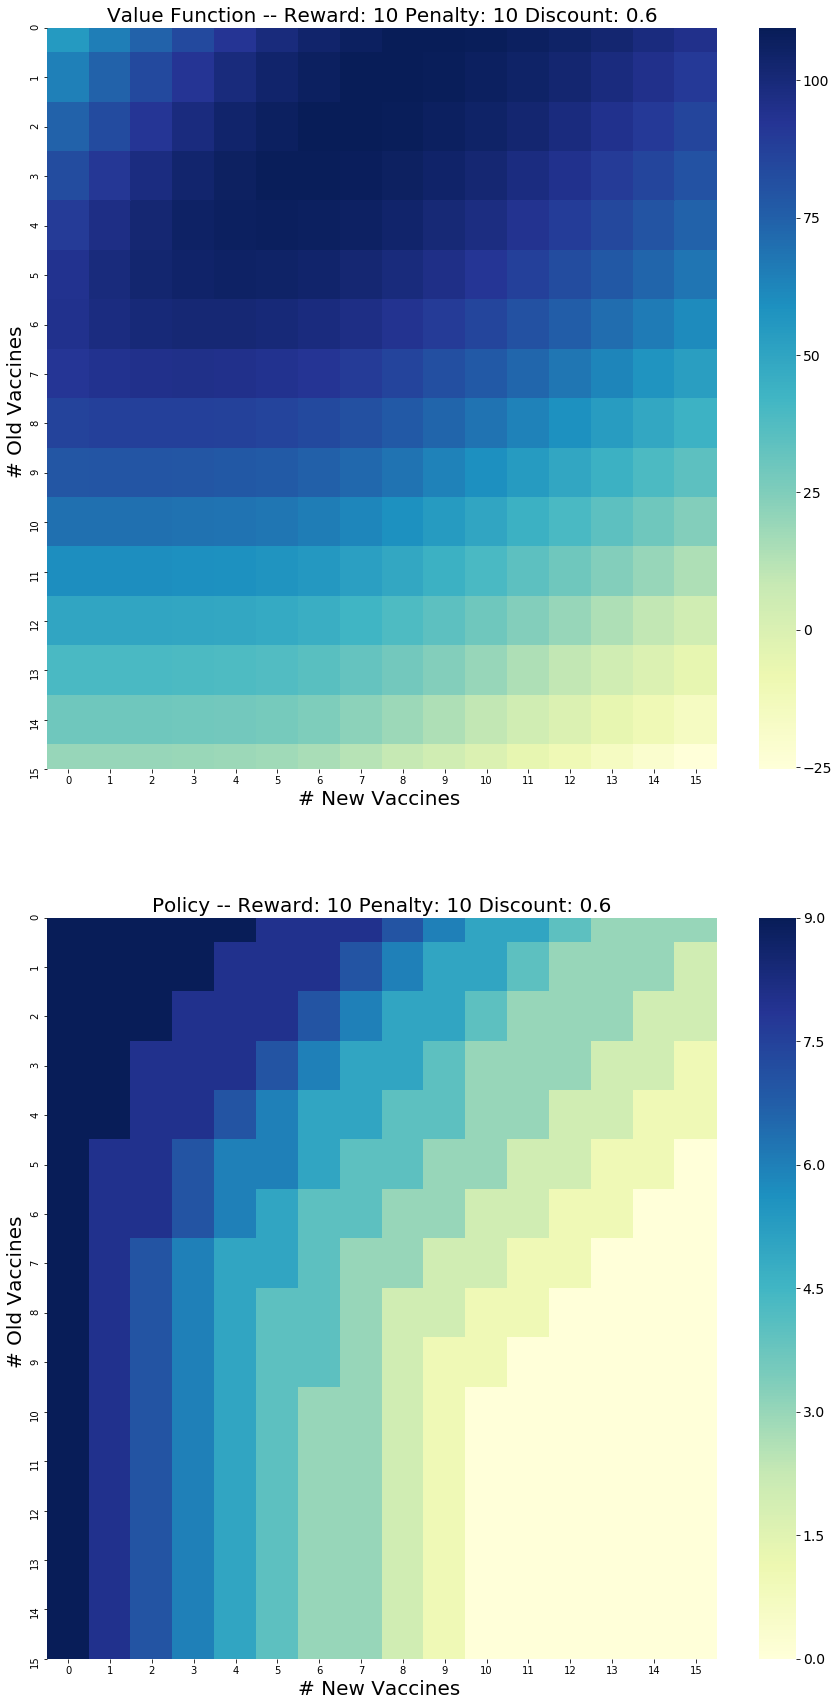

In [8]:
plot_heat_maps(agent.V, agent.policy, centre.fee_vaccine, centre.cost_vaccine)

## Model Free Solution

In [9]:
def epsilon_greedy(q_vec, epsilon=EPSILON):
    """
    Returns the index of the action selected under an epsilon
    greedy policy
    """
    if epsilon < np.random.random():
        return np.argmax(q_vec)
    else:
        return np.random.randint(np.array(q_vec).shape[-1])

In [10]:
def QLearning_policy(q_vec, action):
    """
    Identifies the action which maximises the q_vec
    state-action vector and returns a policy with all
    weight centred on highest value return
    """
    return np.eye(len(q_vec))[np.argmax(q_vec)]


def sarsa_policy(q_vec, action):
    """
    """
    return np.eye(len(q_vec))[action]


def expected_sarsa_policy(q_vec, action, epsilon=EPSILON):
    """
    """
    greedy = QLearning_policy(q_vec, action)
    return greedy - greedy * epsilon + epsilon / len(q_vec)

In [11]:
%%time
alpha_rewards = []
alpha_range = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1]
for alpha in alpha_range:
    print(f'######## Alpha: {alpha} ############')
    centre = drug_centre(cost_vaccine=10, fee_vaccine=10) 
    dist = truncated_patient_arrival_distribution(max_arrivals=10, rate=6) 
    agent = tabular_model_free_agent(
        max_vax=12,
        max_delivery=10,
        alpha = alpha,
        behaviour_policy=epsilon_greedy,
        target_policy=QLearning_policy
    )
    rewards = []
#     results = []
    for i in range(1000000):
        if (i+1) % 100000 == 0:
            print(f"Alpha: {alpha}. Iteration: {i+1}")
        if i == 0:
            next_action = 0
            centre.delivery(next_action)

        centre.delivery(next_action)
        next_state = centre.get_state()
        patient_no = np.argmax(
            np.random.multinomial(1, dist.dist)
        )
        centre.treat_patients(patient_no)
        reward = centre.get_reward()
        next_action = agent.step(reward, next_state)
#         results.append([
#             next_state[0],
#             next_state[1],
#             patient_no,
#             next_action,
#             reward
#         ])
        rewards.append(reward)
    alpha_rewards.append(rewards)

######## Alpha: 0.05 ############
Alpha: 0.05. Iteration: 100000
Alpha: 0.05. Iteration: 200000
Alpha: 0.05. Iteration: 300000
Alpha: 0.05. Iteration: 400000
Alpha: 0.05. Iteration: 500000
Alpha: 0.05. Iteration: 600000
Alpha: 0.05. Iteration: 700000
Alpha: 0.05. Iteration: 800000
Alpha: 0.05. Iteration: 900000
Alpha: 0.05. Iteration: 1000000
######## Alpha: 0.1 ############
Alpha: 0.1. Iteration: 100000
Alpha: 0.1. Iteration: 200000
Alpha: 0.1. Iteration: 300000
Alpha: 0.1. Iteration: 400000
Alpha: 0.1. Iteration: 500000
Alpha: 0.1. Iteration: 600000
Alpha: 0.1. Iteration: 700000
Alpha: 0.1. Iteration: 800000
Alpha: 0.1. Iteration: 900000
Alpha: 0.1. Iteration: 1000000
######## Alpha: 0.2 ############
Alpha: 0.2. Iteration: 100000
Alpha: 0.2. Iteration: 200000
Alpha: 0.2. Iteration: 300000
Alpha: 0.2. Iteration: 400000
Alpha: 0.2. Iteration: 500000
Alpha: 0.2. Iteration: 600000
Alpha: 0.2. Iteration: 700000
Alpha: 0.2. Iteration: 800000
Alpha: 0.2. Iteration: 900000
Alpha: 0.2. Iterat

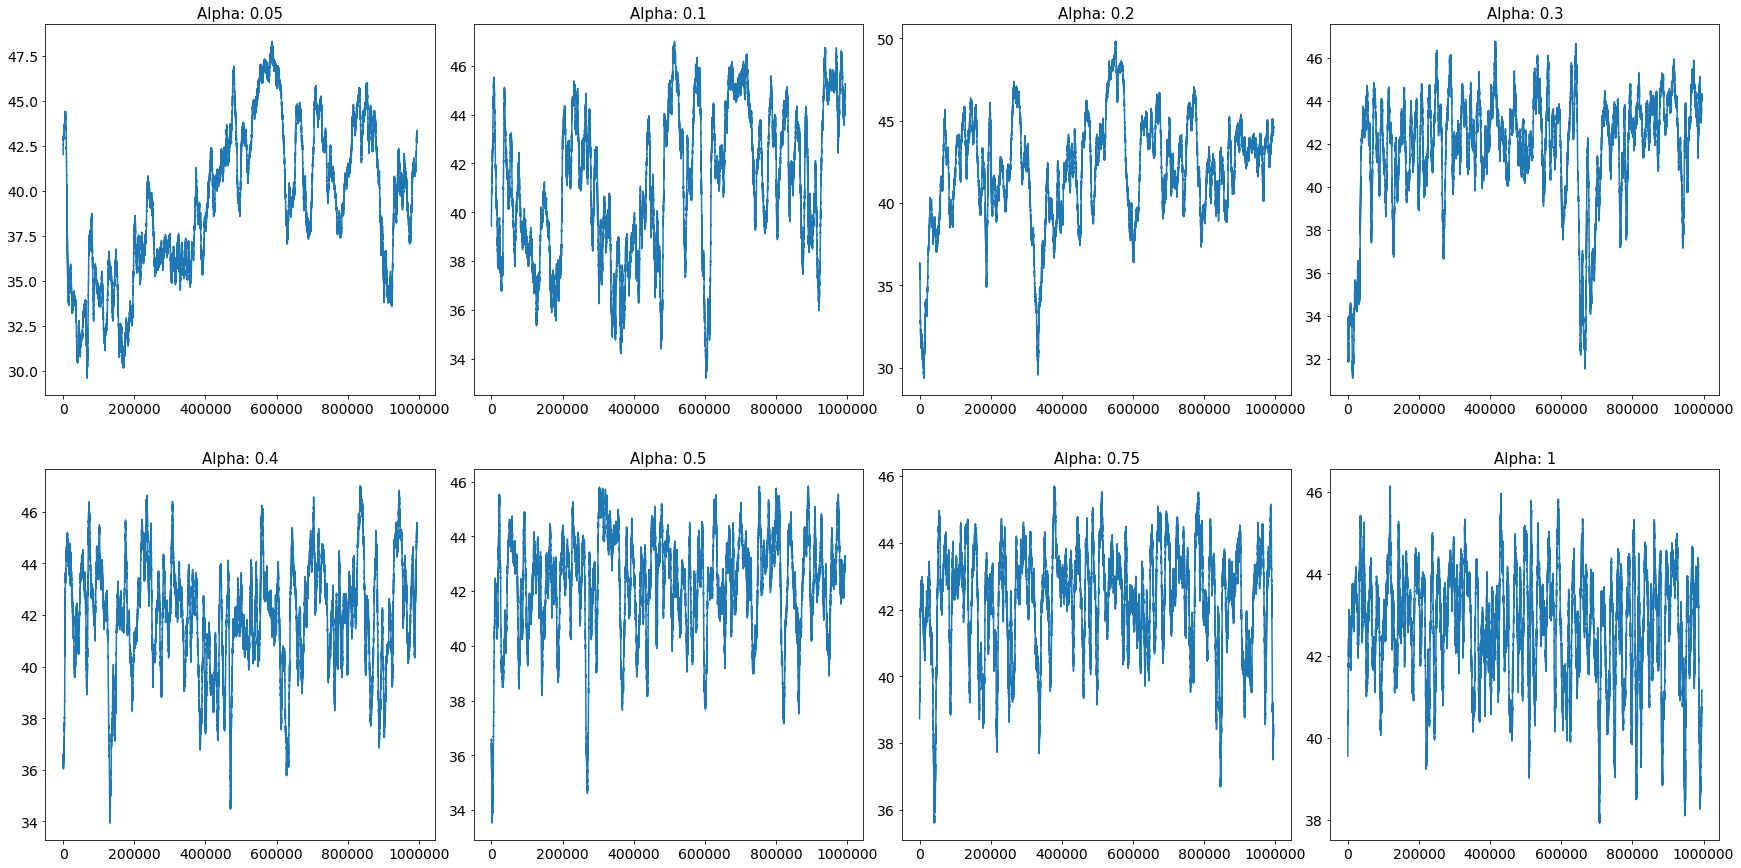

In [12]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

_, axes = plt.subplots(2, 4, figsize=(30, 15))
plt.subplots_adjust(wspace=0.1, hspace=0.2)

alpha_idx = 0
sma_rewards = [moving_average(rewards, 5000) for rewards in alpha_rewards]
for i in range(2):
    for j in range(4):
        axes[i, j].plot(
            moving_average(alpha_rewards[alpha_idx], 5000),
        )
        axes[i, j].set_title(f"Alpha: {alpha_range[alpha_idx]}", fontsize=15)
        alpha_idx += 1

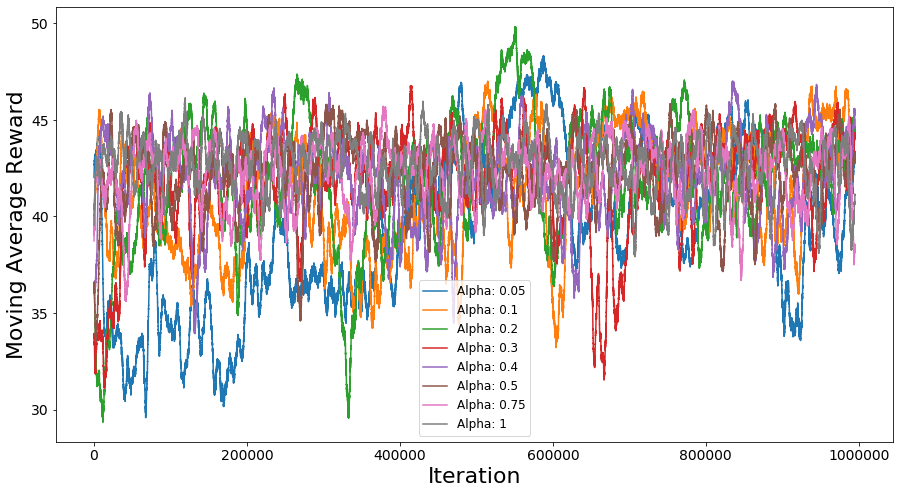

In [19]:
fig = plt.figure(figsize=(15, 8))
for i in range(len(sma_rewards)):
    plt.plot(sma_rewards[i], label=f"Alpha: {alpha_range[i]}")
plt.legend(prop={'size': 12})
plt.xlabel('Iteration')
plt.ylabel('Moving Average Reward')
plt.show()

In [14]:
# Choosing algo with highest mean converged reward for the final quarter of actions
average_final_rewards = []
for i in range(len(alpha_rewards)):
    rewards = alpha_rewards[i]
    average_final_rewards.append(
        np.mean(rewards[int(0.75 * len(rewards)):])
    )
optimal_alpha = alpha_range[int(np.argmax(average_final_rewards))]    
print(
    f"Optimal Hyperparameter: {optimal_alpha}"
)

Optimal Hyperparameter: 0.3


### Calculating Q-learning over best action

In [15]:
centre = drug_centre(cost_vaccine=10, fee_vaccine=10) 
dist = truncated_patient_arrival_distribution(max_arrivals=10, rate=6) 
agent = tabular_model_free_agent(
    max_vax=12,
    max_delivery=12,
    alpha=optimal_alpha,
    behaviour_policy=epsilon_greedy,
    target_policy=QLearning_policy
)
rewards = []
for i in range(1000000):
    if (i+1) % 100000 == 0:
        print(f"Alpha: {optimal_alpha}. Iteration: {i+1}")
    if i == 0:
        next_action = 0
        centre.delivery(next_action)

    centre.delivery(next_action)
    next_state = centre.get_state()
    patient_no = np.argmax(
        np.random.multinomial(1, dist.dist)
    )
    centre.treat_patients(patient_no)
    reward = centre.get_reward()
    next_action = agent.step(reward, next_state)

Alpha: 0.3. Iteration: 100000
Alpha: 0.3. Iteration: 200000
Alpha: 0.3. Iteration: 300000
Alpha: 0.3. Iteration: 400000
Alpha: 0.3. Iteration: 500000
Alpha: 0.3. Iteration: 600000
Alpha: 0.3. Iteration: 700000
Alpha: 0.3. Iteration: 800000
Alpha: 0.3. Iteration: 900000
Alpha: 0.3. Iteration: 1000000


In [16]:
np.set_printoptions(suppress=True)
np.round(agent.q[:,:,6], 2)

array([[ 5.83994386e+43, -4.14411169e+43, -1.20051397e+43,
        -3.59225417e+44, -1.76843071e+44, -3.00080747e+44,
        -2.78903370e+44,  1.08948554e+45, -3.93649440e+44,
        -1.10548986e+45, -2.09180713e+44, -6.58499362e+44,
        -9.98491874e+44],
       [-2.03278560e+44,  6.26409644e+42, -6.39911383e+43,
        -7.46414857e+42,  3.02084092e+41, -1.20539869e+44,
        -1.08996066e+44, -1.76107253e+44, -3.39027312e+44,
        -4.19250923e+44,  6.77369069e+43, -1.20533914e+43,
        -2.66206492e+44],
       [-2.11364314e+44, -5.10041279e+41, -1.63188475e+43,
        -6.56445646e+43, -1.21651714e+44, -1.92935389e+44,
        -4.10835044e+44, -3.53209448e+44, -2.13467588e+44,
        -1.20562999e+44, -2.83807728e+44, -1.38180958e+44,
        -5.07983686e+44],
       [-1.77271105e+44, -8.87786131e+43, -4.84319282e+42,
         4.82600096e+41, -1.16165229e+44, -1.47894242e+44,
        -1.88864754e+44, -6.07654327e+44, -2.54254315e+44,
        -1.04532952e+44, -4.39675354e

In [17]:
np.argmax(agent.q, axis=-1)

array([[ 9,  8,  9, 11,  9,  9, 12,  6,  8, 11,  5, 10,  7],
       [ 9,  9,  8, 11,  9, 12,  8, 12,  7,  8,  6,  0,  0],
       [ 9,  9, 11, 12,  9,  8, 11,  9, 12,  7,  6, 10, 11],
       [ 9,  9,  9,  8,  9,  2,  6, 11,  6,  7,  7, 10,  2],
       [ 9, 12, 11, 10, 12,  7,  6,  7,  4,  7, 11,  6,  6],
       [ 9, 12, 12, 10, 12,  7,  6, 11, 11,  0, 10,  7,  5],
       [12,  9,  7, 10, 10,  7, 11, 11,  0,  3,  5,  2, 10],
       [ 9,  8, 10, 10,  1,  5,  0,  7,  2,  1, 11, 11, 10],
       [12,  9,  8, 10,  1, 11, 10, 11, 10,  9,  7, 10,  7],
       [11, 10,  6,  7,  5, 11,  8,  6, 10, 11,  7,  8, 10],
       [ 9,  9, 12,  6,  5,  4,  9, 11, 10, 10, 10,  8, 10],
       [12, 10, 12,  8, 12,  7, 11, 10,  9, 11,  5, 11,  7],
       [10,  9, 10,  7, 11,  8,  8,  6, 10,  5, 10,  1, 10]])

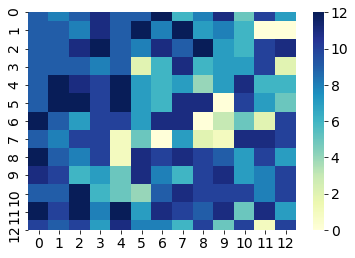

In [18]:
fig = sns.heatmap(
    np.argmax(agent.q, axis=-1),
    cmap="YlGnBu",
)

In [25]:
EPSILON

0.1